In [87]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [88]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [89]:
df = pd.read_csv("data/my_horizon_data_all.csv", dtype={"subject": str})

# files = [
#     "data/my_horizon_data.csv",
#     "data/my_horizon_data_0919.csv",
# ]
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [90]:
df.head()

,subject,block,m1,m2,uc,gameLength,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,0,0,40,36,1,6,18,-99,0,42,...,184.143661,4.635614,1.122532,2.833540,2.738855,5.263696,5.763985,1.940346,0.937745,2.472841
1,0,1,60,48,0,6,18,-99,0,67,...,1.184903,1.013671,1.305989,8.874533,2.708196,2.426142,1.115581,1.370487,1.103393,1.046302
2,0,2,40,36,0,6,18,-99,0,37,...,0.832413,0.468084,0.566725,0.445963,1.810017,1.325654,0.892086,0.780645,1.881181,0.576540
3,0,3,40,48,0,1,18,-99,0,58,...,0.830383,0.553779,0.817720,1.686227,0.910277,NaN,NaN,NaN,NaN,NaN
4,0,4,40,10,0,1,18,-99,0,4,...,0.663673,1.049479,0.692706,3.581879,4.616839,NaN,NaN,NaN,NaN,NaN


In [91]:

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = ['c4', 'c5', 'c6', 'c7', 'c8', 'c9']


X_seq = df[seq_features]
X_static = df[static_features]

y = df[target]
PAD_IDX = -100
y = df[['c4','c5','c6','c7','c8','c9']].copy() 
y = y.fillna(PAD_IDX)


print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)

print("After scaling:")
print(f'X_seq_train {X_seq_train[0]} shape {X_seq_train.shape}')
print(f'X_static_train {X_static_train[0]} shape {X_static_train.shape}')
print(f'y_train {y_train.iloc[0]} shape {y_train.shape}')

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
1  67.0  0.0  57.0  1.0  56.0  0.0  50.0  1.0
2  37.0  1.0  48.0  0.0  23.0  0.0  39.0  1.0
3  58.0  1.0  51.0  0.0  28.0  0.0  47.0  1.0
4   4.0  1.0  30.0  0.0  11.0  1.0  37.0  0.0
   gameLength  uc
0           6   1
1           6   0
2           6   0
3           1   0
4           1   0

--- Target Data (y) ---
    c4     c5     c6     c7     c8     c9
0  0.0    1.0    1.0    1.0    1.0    1.0
1  0.0    0.0    0.0    0.0    0.0    0.0
2  0.0    1.0    0.0    0.0    0.0    1.0
3  1.0 -100.0 -100.0 -100.0 -100.0 -100.0
4  0.0 -100.0 -100.0 -100.0 -100.0 -100.0
After scaling:
X_seq_train [-0.38649261  0.96221224  0.20634578 -1.00385279  1.15776823  1.03427041
  0.33675682  1.00923939] shape (136788, 8)
X_static_train [0.999503   1.37599616] shape (136788, 2)
y_train c4    0.0
c5    1.0
c6    1.0

In [92]:
TIME_STEPS = 4
SEQ_LEN = len(seq_features) // TIME_STEPS
print(f"SEQ_LEN: {SEQ_LEN}")

SEQ_LEN: 2


In [93]:
feature_order_test = np.array(seq_features).reshape(-1, TIME_STEPS, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [94]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(136788, 8)
(34197, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [95]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, TIME_STEPS, SEQ_LEN)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, TIME_STEPS, SEQ_LEN)
print(X_seq_test.shape)
print(type(X_seq_test))

(136788, 4, 2)
<class 'numpy.ndarray'>
[[-0.38649261  0.96221224]
 [ 0.20634578 -1.00385279]
 [ 1.15776823  1.03427041]
 [ 0.33675682  1.00923939]]
(34197, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [96]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [97]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [98]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [99]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [100]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [ ]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, 
                 output_size=2, max_out_len=6, pad_idx=-100):
        super(Seq2SeqGRU, self).__init__()

        self.hidden_size = hidden_size
        self.max_out_len = max_out_len
        self.pad_idx = pad_idx
        self.output_size = output_size

        self.encoder = nn.GRU(seq_input_size, hidden_size, batch_first=True)

        # encoder hidden + static
        self.fc_static = nn.Linear(hidden_size + static_input_size, hidden_size)

        # Decoder: input = one-hot choice vector (dim = output_size)
        self.decoder = nn.GRU(output_size, hidden_size, batch_first=True)

        self.out = nn.Linear(hidden_size, output_size)


    def forward(self, seq_x, static_x, targets=None, teacher_forcing_ratio=1.0):
        # --- Encode ---
        _, h_n = self.encoder(seq_x)        # h_n: [1, B, hidden]
        h_n = h_n.squeeze(0)                # [B, hidden]
        combined = torch.cat((h_n, static_x), dim=1)
        encoder_output = self.fc_static(combined).unsqueeze(0)  # [1, B, hidden]

        # --- Decode ---
        outputs = []
        batch_size = seq_x.size(0)
        device = seq_x.device

        decoder_input = torch.zeros(batch_size, 1, self.output_size, device=device)  # start token (all zeros)
        hidden = encoder_output

        for t in range(self.max_out_len):
            dec_out, hidden = self.decoder(decoder_input, hidden)  # dec_out: [B, 1, hidden]
            logits = self.out(dec_out)                            # [B, 1, output_size]
            outputs.append(logits)

            # Teacher forcing toggle
            use_teacher_forcing = (targets is not None) and (random.random() < teacher_forcing_ratio)
            if use_teacher_forcing:
                target_t = targets[:, t]                          # [B]
                one_hot = torch.zeros(batch_size, self.output_size, device=device)
                valid_mask = (target_t != self.pad_idx)
                one_hot[valid_mask, target_t[valid_mask]] = 1.0
                decoder_input = one_hot.unsqueeze(1)              # [B, 1, output_size]
            else:
                decoder_input = torch.softmax(logits, dim=-1)     # [B, 1, output_size]

        outputs = torch.cat(outputs, dim=1)  # [B, max_out_len, output_size]
        return outputs

# train / eval

In [102]:
def stepwise_accuracy(logits, labels, pad_idx=-100):
    preds = logits.argmax(dim=-1)  # [B, L]
    L = labels.size(1)
    accs = []

    for t in range(L):
        mask = labels[:, t] != pad_idx
        if mask.sum() > 0:
            correct = (preds[:, t][mask] == labels[:, t][mask]).sum().item()
            accs.append(correct / mask.sum().item())
        else:
            accs.append(float('nan')) 
    return accs

In [103]:
def train(model, train_loader, criterion, optimizer, device, pad_idx=-100):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        logits = model(seq_inputs, static_inputs, targets=labels, teacher_forcing_ratio=1.0)
        loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=-1)
        mask = labels != pad_idx
        correct += (preds[mask] == labels[mask]).sum().item()
        total += mask.sum().item()
        train_loss += loss.item() * seq_inputs.size(0)

    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return accuracy, avg_loss


def test(model, test_loader, criterion, device, pad_idx=-100):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    step_acc_sum = None
    n_batches = 0

    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            logits = model(seq_inputs, static_inputs, teacher_forcing_ratio=0.0)
            loss = criterion(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            preds = logits.argmax(dim=-1)
            mask = labels != pad_idx
            correct += (preds[mask] == labels[mask]).sum().item()
            total += mask.sum().item()
            total_loss += loss.item() * seq_inputs.size(0)

            # step-wise accuracy for this batch
            batch_step_accs = stepwise_accuracy(logits, labels, pad_idx)
            if step_acc_sum is None:
                step_acc_sum = [0.0] * len(batch_step_accs)
            for i, acc in enumerate(batch_step_accs):
                if not (acc != acc):  # skip NaNs
                    step_acc_sum[i] += acc
            n_batches += 1

    accuracy = correct / total
    avg_loss = total_loss / len(test_loader.dataset)
    step_accs = [a / n_batches for a in step_acc_sum]
    return accuracy, avg_loss, step_accs

In [104]:
def train_and_evaluate(model, train_loader, test_loader, test_loader_h1, test_loader_h6,
                       criterion, optimizer, device, epochs, pad_idx=-100):
    train_loss_prog, train_acc_prog = [], []
    test_loss_prog, test_acc_prog = [], []
    test_acc_h1_prog, test_loss_h1_prog, test_step_h1_prog = [], [], []
    test_acc_h6_prog, test_loss_h6_prog, test_step_h6_prog = [], [], []

    best_loss = float('inf')
    patience, epochs_no_improve = 5, 0
    final_epoch = epochs

    for epoch in range(epochs):
        train_acc, train_loss = train(model, train_loader, criterion, optimizer, device, pad_idx)
        test_acc, test_loss, _ = test(model, test_loader, criterion, device, pad_idx)
        test_acc_h1, test_loss_h1, step_acc_h1 = test(model, test_loader_h1, criterion, device, pad_idx)
        test_acc_h6, test_loss_h6, step_acc_h6 = test(model, test_loader_h6, criterion, device, pad_idx)

        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: overall {test_acc:.3f}, H1 {test_acc_h1:.3f}, H6 {test_acc_h6:.3f}")

        # log
        train_acc_prog.append(train_acc); train_loss_prog.append(train_loss)
        test_acc_prog.append(test_acc); test_loss_prog.append(test_loss)
        test_acc_h1_prog.append(test_acc_h1); test_loss_h1_prog.append(test_loss_h1); test_step_h1_prog.append(step_acc_h1)
        test_acc_h6_prog.append(test_acc_h6); test_loss_h6_prog.append(test_loss_h6); test_step_h6_prog.append(step_acc_h6)

        # early stopping
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve > patience:
            print(f"Early stopping at epoch {epoch+1}, best loss {best_loss:.4f}")
            final_epoch = epoch+1
            break

    return {
        "train_acc": train_acc_prog,
        "train_loss": train_loss_prog,
        "test_acc": test_acc_prog,
        "test_loss": test_loss_prog,
        "h1_acc": test_acc_h1_prog,
        "h1_loss": test_loss_h1_prog,
        "h1_step_acc": test_step_h1_prog,
        "h6_acc": test_acc_h6_prog,
        "h6_loss": test_loss_h6_prog,
        "h6_step_acc": test_step_h6_prog,
        "final_epoch": final_epoch
    }

# running experiment

## single model

In [105]:
# model = TinyAttentionNoProj().to(device)
# print(model)

In [106]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# epochs = 100
# loss_prog, acc_prog, acc_h1_prog, acc_h6_prog, final_epoch = train_and_evaluate(model, train_loader, criterion, optimizer, device, epochs=epochs)

## multiple models

In [107]:
model_dict = {
    # "RNN": RNN().to(device),
    # "LSTM": LSTM().to(device),
    # "GRU": GRU().to(device),
    # "TinyGRU": TinyGRU().to(device),
    # "Transformer": TransformerEncoderPositionalEncoding().to(device),
    # "SelfAttention": SelfAttentionOnly().to(device),
    # "TinyAttentionNoProj": TinyAttentionNoProj().to(device),
    "Seq2SeqGRU": Seq2SeqGRU().to(device),
}

In [108]:
epochs = 100
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(
        model,
        train_loader,
        test_loader,
        test_loader_h1,
        test_loader_h6,
        criterion,
        optimizer,
        device,
        epochs=epochs
    )

    model_dict[model_name] = {
        "model": model,
        "train_loss_prog": history["train_loss"],
        "train_acc_prog": history["train_acc"],
        "test_loss_prog": history["test_loss"],
        "test_acc_prog": history["test_acc"],
        "test_step_acc_prog": history["step_acc"],       
        "test_step_acc_h1_prog": history["step_acc_h1"], 
        "test_step_acc_h6_prog": history["step_acc_h6"], 
        "test_acc_h1_prog": history["h1_acc"],
        "test_loss_h1_prog": history["h1_loss"],
        "test_acc_h6_prog": history["h6_acc"],
        "test_loss_h6_prog": history["h6_loss"],
        "final_epoch": history["final_epoch"]
    }


Training model: Seq2SeqGRU
Epoch 1: overall 0.769, H1 0.815, H6 0.761
Early stopping at epoch 7, best loss 0.5123


KeyError: 'step_acc'

# plotting

In [109]:
import matplotlib.pyplot as plt

In [135]:

def plot_h6_stepwise(history, model_name="Seq2SeqGRU"):
    final_acc_h6 = history["h6_step_acc"][-1]   # [acc_c4,...,acc_c9]
    final_acc_h1 = history["h1_acc"][-1]        # single value

    trials = [f"c{i}" for i in range(4, 10)]

    plt.figure(figsize=(6,4))
    plt.plot(trials, final_acc_h6, marker="o", linestyle="-", color="blue", label="H6")
    plt.axhline(y=final_acc_h1, color="red", linestyle="--", label="H1")

    plt.ylim(0.7, 0.85)
    plt.xlabel("Game trial")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name}")
    plt.legend()
    # plt.grid(alpha=0.3)
    plt.show()

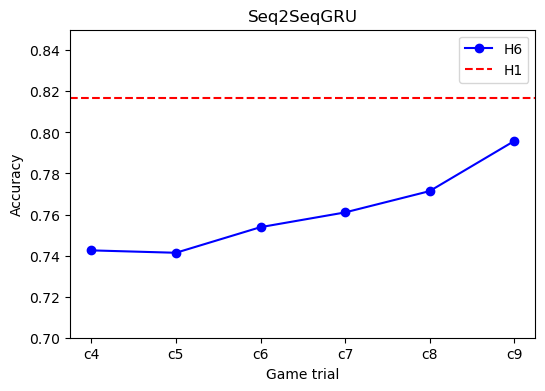

In [136]:
plot_h6_stepwise(history, model_name="Seq2SeqGRU")